# Bias and Word Embeddings (Part 2)

This is the second Jupyter Notebook complementing my blog post. If you're looking for the previous one, it's in the same Github repo!

In our previous notebook, we ended up looking at vectors for people that were close to two terms that could cause bias, but that method wasn't too effective. Let's take another look at the embeddings and apply another linear algebra technique, but first, let's make sure we have all our functions and data ready.

## Setup

Reading in data and copying over some functions from our previous notebook.

In [2]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet as wn
from sklearn.decomposition import PCA 
from matplotlib import pyplot as plt

In [3]:
#Reading data
f = open('glove.6B/glove.6B.100d.txt', 'r') 
vocab = []
embeddings = {}
matrix = []
for line in f:
    split_line = line.split()
    word = split_line[0]
    vector = np.asarray([float(i) for i in split_line[1:]])
    embeddings.update({word:vector})
    vocab.append(word)
    matrix.append(vector)
#PCA
pca = PCA(n_components = 2)
mtx_2d = pca.fit_transform(matrix)
embeddings_2d = {vocab[i]:mtx_2d[i] for i in np.arange(len(vocab))}


In [12]:
#Plotting Function
def plot_embeddings(word_lst, embedding_dict, dot_color, labels = True):
    """Takes in a list of words to be plotted, their 2-dimensional embeddings, 
    the color of the dots, and whether the dots should be labeled,
    makes a scatterplot of the word vectors"""
    coords = [embedding_dict[word] for word in word_lst]
    extract_coords = lambda tuple_index: [c[tuple_index] for c in coords] 
    x = extract_coords(0)
    y = extract_coords(1)
    fig, ax = plt.subplots()
    ax.scatter(x, y, color = dot_color)
    if labels:
        for i in np.arange(len(word_lst)):
            ax.annotate(word_lst[i], (x[i] + 0.05, y[i] + 0.05))
    return ax

In [6]:
#Filtering out people and male/female-specific words
def get_hyponyms(synset):
    """Get all words that are considered subcategories, or hyponyms of a particular noun.
    Takes in a WordNet Synset object, returns a set of words that are part of that synset"""
    hyponyms = set()
    for hyponym in synset.hyponyms():
        hyponyms |= set(get_hyponyms(hyponym)) #Gets union of all the hyponyms of the word
    hyponyms = hyponyms | set(synset.hyponyms())
    return hyponyms

types_of_people = {synset.name().split('.')[0] for synset in get_hyponyms(wn.synset('person.n.01'))}

male_words=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his',
                'boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers',
                'fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself',
                'husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son',
                'sons','uncle','uncles','waiter','widower','widowers'])
female_words=set(['heroine','spokeswoman','chairwoman',"women's",
                  'actress','women',"she's",'her','aunt','aunts','bride',
                  'daughter','daughters','female','fiancee','girl','girlfriend','girlfriends','girls',
                  'goddess','granddaughter','grandma','grandmother','herself','ladies','lady','lady','mom',
                  'moms','mother','mothers','mrs','ms','niece','nieces','priestess','princess','queens','she',
                  'sister','sisters','waitress','widow','widows','wife','wives','woman'])
def gender_neutral(word):
    """Takes in a word and returns True if the word does not belong to """
    return (word not in male_words) and (word not in female_words) and (not word.endswith('man')) and (not word.endswith('woman'))


## Projections onto Vector Spaces 

For a different approach, we'll turn to [Bolukbasi et al (2016)](https://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf). As detailed in the paper, if we compare one vector and the vector representing the difference between two words in a relation, we'll get to see how biased that word is in comparison to the rest of the words in our dataset. 
This allows us to quantify how biased a certain embedding is. For instance, let's see what happens to our embeddings when compared to $she - he$. We'll essentially be able to "rank" word embeddings from how "male," "female," or "neutral" they are.


In linear algebra terms, the vector is being projected onto the space spanned by the biased words via taking the dot product. For the sake of simplicity, I performed a scalar projection, but similar results could be obtained by projecting a certain word onto a basis formed by multiple vectors exhibiting the same relationship (e.g. projecting the vector for "engineer" onto the space spanned by $[he - she, him - her, father - mother]$).

In [7]:
def projection(word1, word2, filter_people = False, entire_list = False):
    """Takes in two words and boolean flags to remove people and return the entire list
    Returns the "scores" for the embeddings when projected onto the space of word1 - word2
    as a list of tuples in the format(word, score). 
    Can return scores for the entire dataset or the top and bottom 30 words.
    """
    dot_products = {}
    target_vector = embeddings[word1] - embeddings[word2]
    for e in embeddings:
        if (filter_people and e in types_of_people) or not filter_people:
            dot_products[e] = np.dot(embeddings[e], target_vector)
    sorted_by_value = sorted(dot_products.items(), key=lambda kv: kv[1])
    if entire_list:
        return sorted_by_value
    else:
        return sorted_by_value[:30], sorted_by_value[-30:]

In [8]:
"""Masculine" words end up having to do with sports, clergy, or military,
and "feminine" words have to do with service or performance-based occupations"""
projection('he', 'she', filter_people = True)

([('actress', -9.741748064429),
  ('princess', -8.2977127146939),
  ('girl', -7.9675635360169395),
  ('mother', -7.769731536065),
  ('sister', -7.471787558951999),
  ('daughter', -7.306648032271999),
  ('baby', -7.2921818369530005),
  ('archduchess', -7.2662344563023),
  ('soprano', -7.214419258906201),
  ('girlfriend', -7.132530076883981),
  ('mezzo-soprano', -7.0743003058341),
  ('ballerina', -7.025223175676199),
  ('aunt', -6.9974255033244),
  ('woman', -6.759235861828801),
  ('bride', -6.7585562751939),
  ('bonesetter', -6.69312866719482),
  ('nude', -6.3830906470498),
  ('duchess', -6.375533436343499),
  ('countrywoman', -6.353722345177401),
  ('spokeswoman', -6.290264946293),
  ('supermodel', -6.2762004748088005),
  ('countess', -6.2387458118624),
  ('heiress', -6.2334643744697),
  ('lesbian', -6.231205399075699),
  ('waitress', -6.2008776042276),
  ('dowager', -6.144607161782999),
  ('contralto', -6.0677067817463),
  ('housewife', -6.02619656565),
  ('wife', -6.0063985339445995)

In [9]:
"""More "Islamic" words deal with specific nationalities and extremism,
whereas "Christian" words have much more religious terminology."""
projection('christianity', 'islam', filter_people=True)

([('sheik', -15.546444359754002),
  ('shiite', -13.3892383807616),
  ('cleric', -12.97782765841616),
  ('islamist', -12.826093810900701),
  ('militant', -12.744860293783123),
  ('khan', -12.0652203077023),
  ('ayatollah', -11.73036697325079),
  ('malik', -11.38191754419843),
  ('saudi', -10.969776286425098),
  ('kuwaiti', -10.25835620512635),
  ('mullah', -10.079902465676202),
  ('emir', -10.07938093962725),
  ('shah', -10.0476158693841),
  ('terrorist', -10.007341874217381),
  ('muslim', -9.7827428514392),
  ('imam', -9.744088641475699),
  ('extremist', -9.711091726552),
  ('sultan', -9.687855511136299),
  ('iraqi', -9.6223412953838),
  ('pakistani', -9.599836039796902),
  ('libyan', -9.3938534076552),
  ('terror', -9.385949100010201),
  ('uzbek', -9.3312674608702),
  ('palestinian', -9.158623876443),
  ('yemeni', -9.149156178311701),
  ('jordanian', -9.125806133239086),
  ('leader', -8.941583877939301),
  ('hakim', -8.9370696111248),
  ('anti', -8.935580847459502),
  ('bahraini', -8.

In [10]:
"""Words closer to "worker" often describe ethnicities and even specify "woman,"
while words closer to "manager" include "sir" """
projection('manager', 'worker', filter_people = True)

([('worker', -16.87209311681928),
  ('migrant', -16.3595606477),
  ('peasant', -13.942771588777102),
  ('immigrant', -13.4315754368361),
  ('inmate', -12.59205339561922),
  ('suffragist', -12.426003447547501),
  ('laborer', -12.0317953378371),
  ('uighur', -11.302204098906701),
  ('tibetan', -11.079728787303),
  ('woman', -11.0482056566408),
  ('nun', -10.9484827003085),
  ('refugee', -10.878285677038498),
  ('hostage', -10.733414983323001),
  ('child', -10.658395350925872),
  ('sorbian', -10.636260892329041),
  ('midwife', -10.575435520218601),
  ('settler', -10.513133718547),
  ('amish', -10.382819463513599),
  ('slave', -10.156010342711319),
  ('photojournalist', -10.011237752311622),
  ('heterosexual', -10.003404216810761),
  ('kashmiri', -9.932657051780101),
  ('czarina', -9.8482999057465),
  ('suffragette', -9.806862267164101),
  ('adoptee', -9.76670261507644),
  ('molester', -9.721460907977232),
  ('homosexual', -9.714815839023),
  ('illiterate', -9.712079677953799),
  ('nepales

## Visualizing Bias

Using our results from the last part combined with the results of our PCA, let's try to plot a couple graphs of "biased" words. We're going to do this by multiplying the coordinates for each word by its score from a projection.

In [13]:
def scale_embeddings(proj_lst, embedding_dict):
    """Takes in a list outputted by the projection function and a dictionary of 2D embeddings,
    Returns dictionary of 2D embeddings multiplied by the scalar projection"""
    scaled = {}
    for i in proj_lst:
        word = i[0]
        scaled[word] = embedding_dict[word] * i[1]
    return scaled

def select_words(word_lst, k):
    """Takes in a list of words and step size,
    Returns randomly selected list of words from the list.
    I don't use this function but feel free to experiment!"""
    plot_words = []
    for i in np.arange(0, len(word_lst), k):
        if i + (k - 1) > len(word_lst):
            plot_words.append(word_lst[np.random.randint(i, len(word_lst))])
        else:
            plot_words.append(word_lst[np.random.randint(i, i + (k - 1))][0])
    return plot_words

def center_spines(ax=None, centerx=0, centery=0):
    """Centers a plot at 0, 0, modifies result of plot_embeddings"""
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
def plot_scaled_embeddings(word1, word2, color, word_lst, people = True):
    """Takes in 2 words, dot color, list of words to plot, and a flag to include people
    Plots the embeddings projected on the space denoted by word1 - word2"""
    scalars = projection(word1, word2, filter_people = people, entire_list = True)
    scaled_vectors = scale_embeddings(scalars, embeddings_2d)
    labeled_graph = True
    if len(word_lst) > 20:
        labeled_graph = False
    plot = plot_embeddings(word_lst, scaled_vectors, color, labels = labeled_graph)
    center_spines(plot)

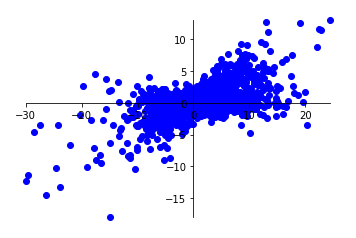

In [14]:
#All the words for people, transformed based on gender 
all_people = [e for e in embeddings if e in types_of_people]
plot_scaled_embeddings('he', 'she', 'blue', all_people)

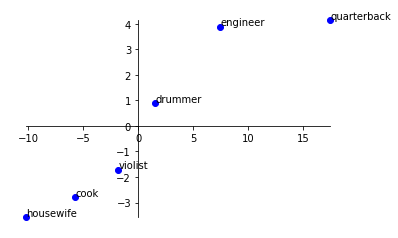

In [15]:
plot_scaled_embeddings('he', 'she', 'blue', ['engineer','cook', 'housewife', 'quarterback', 'violist', 'drummer'])
#Quadrant 1 has "masculine" words and Quadrant 3 has "feminine" words

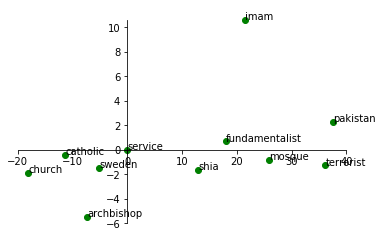

In [26]:
"""More "political" words are associated with the vector for Islam in this dataset. It's also interesting to note that 
"service" appears to be more or less neutral with this projection"""
plot_scaled_embeddings('islam', 'christianity', 'green', 
                       ['fundamentalist', 'archbishop', 'imam', 'church', 
                        'service', 'terrorist', 'mosque', 'catholic', 'shia', 'pakistan', 'sweden'],
                      people = False)
